# Random Forest 
In this notebook we present a Random Forest model. We train GroupKFold models for each of the 18 questions. We infer test using one of our KFold models. Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
clear()

# Load Train Data and Labels

In [3]:
# train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv')
# print( train.shape )
# train.head()

In [4]:
# READ USER ID ONLY
tmp = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [5]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [6]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


# Feature Engineer

In [7]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [8]:
def feature_engineer(train):
#     dfs = []
#     for c in CATS:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
#         tmp.name = tmp.name + '_nunique'
#         dfs.append(tmp)
#     for c in NUMS:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
#         dfs.append(tmp)
#     for c in NUMS:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('std')
#         tmp.name = tmp.name + '_std'
#         dfs.append(tmp)

    #drop columns we dont care about 
    train = train.drop(labels=['level', 'text_fqid'], inplace=False, axis = 1)
    
    #normalize continuous variables
    CONT = ['elapsed_time' , 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

    for i in CONT:
        train[i].fillna(train[i].mean(), inplace=True)
      #  FILL IN THE MISSING VALUES W AVERAGE
        train[i] = (train[i]-train[i].min())/(train[i].max()-train[i].min())
    train.describe()
    
    #create dummie variables
    CAT = ['event_name', 'room_fqid']
    train = pd.get_dummies(train, columns=CAT, drop_first=True)
    
    #turn name into binary
    train['name'] = train['name'].replace(to_replace=['basic', 'undefined'], value=0)
    train['name'] = train['name'].replace(to_replace=['close', 'open', 'prev', 'next'], value=1)
    train['name'].astype(int) 
    
    #turn text into binary
    train['text'] = train['text'].replace(to_replace=[np.nan, 'undefined'], value=0)
    train.loc[train['text']!=0, ['text']] = 1
    train['text'].astype(int)
    
    #turn fqid into binary
    train['fqid'] = train['fqid'].replace(to_replace=[np.nan], value=0)
    train['fqid'][train['fqid'] != 0] = 1
    train['fqid'].astype(int)
    
    #turn page into binary
    train['page'] = train['page'].replace(to_replace=[np.nan, 'undefined'], value=0)
    train['page'][train['page'] != 0] = 1
    train['page'].astype(int)
    
#     train = pd.concat(train,axis=1)
    train = train.fillna(-1)
    train = train.reset_index()
    train = train.set_index('session_id')
    return train

In [9]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2684191, 44)
CPU times: user 7.74 s, sys: 1.13 s, total: 8.87 s
Wall time: 8.85 s


,level_0,index,elapsed_time,name,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,...,room_fqid_tunic.historicalsociety.collection,room_fqid_tunic.historicalsociety.collection_flag,room_fqid_tunic.historicalsociety.entry,room_fqid_tunic.historicalsociety.frontdesk,room_fqid_tunic.historicalsociety.stacks,room_fqid_tunic.humanecology.frontdesk,room_fqid_tunic.kohlcenter.halloffame,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0,0,0.000000,0,0.0,0.485514,0.520984,0.198020,0.343056,0.000032,...,0,0,0,0,0,0,0,0,0,0
20090312431273200,1,1,0.000002,0,0.0,0.485514,0.520984,0.198020,0.343056,0.000032,...,0,0,0,0,0,0,0,0,0,0
20090312431273200,2,2,0.000001,0,0.0,0.485514,0.520984,0.198020,0.343056,0.000032,...,0,0,0,0,0,0,0,0,0,0
20090312431273200,3,3,0.000002,0,0.0,0.485514,0.520984,0.198020,0.343056,0.000032,...,0,0,0,0,0,0,0,0,0,0
20090312431273200,4,4,0.000003,0,0.0,0.485822,0.520984,0.198541,0.343056,0.000032,...,0,0,0,0,0,0,0,0,0,0


# Train Random Forest Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [10]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 43 features
We will train with 2357 users info


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

def searchP(X, y):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 10]}
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    print("Best hyperparameters: ", grid_search.best_params_)

In [12]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier(max_depth=6) 
        
        # search for hyperparameters for each fold each question
#         searchP(train_x[FEATURES].astype('float32'), train_y['correct'])
      

        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [13]:
import pickle

# save model
pickle.dump( models, open( "/kaggle/working/models.p", "wb" ) )

In [14]:
import pickle

#load model from save
models1 = pickle.load( open( "/kaggle/working/models.p", "rb" ) )
models1

{'0-4_1': RandomForestClassifier(max_depth=6),
 '0-4_2': RandomForestClassifier(max_depth=6),
 '0-4_3': RandomForestClassifier(max_depth=6),
 '5-12_4': RandomForestClassifier(max_depth=6),
 '5-12_5': RandomForestClassifier(max_depth=6),
 '5-12_6': RandomForestClassifier(max_depth=6),
 '5-12_7': RandomForestClassifier(max_depth=6),
 '5-12_8': RandomForestClassifier(max_depth=6),
 '5-12_9': RandomForestClassifier(max_depth=6),
 '5-12_10': RandomForestClassifier(max_depth=6),
 '5-12_11': RandomForestClassifier(max_depth=6),
 '5-12_12': RandomForestClassifier(max_depth=6),
 '5-12_13': RandomForestClassifier(max_depth=6),
 '13-22_14': RandomForestClassifier(max_depth=6),
 '13-22_15': RandomForestClassifier(max_depth=6),
 '13-22_16': RandomForestClassifier(max_depth=6),
 '13-22_17': RandomForestClassifier(max_depth=6),
 '13-22_18': RandomForestClassifier(max_depth=6)}

# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [15]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [16]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

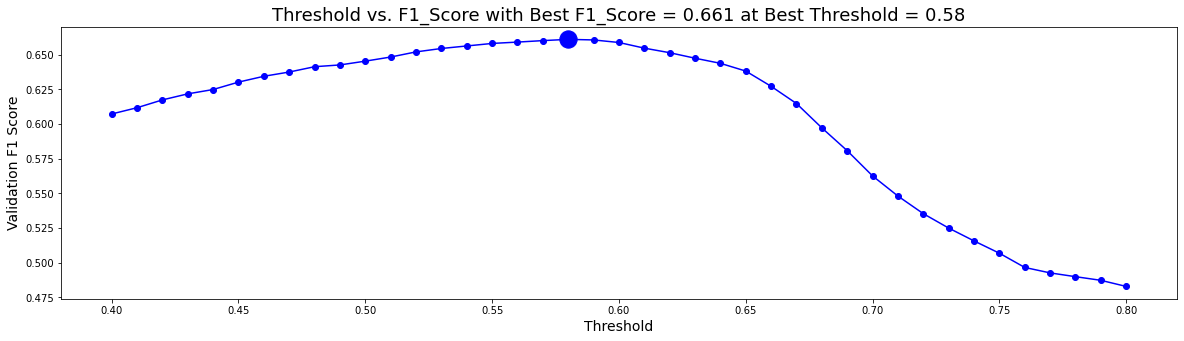

In [17]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [18]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5666042104527871
Q1: F1 = 0.4962598845907245
Q2: F1 = 0.48152221733392
Q3: F1 = 0.5375221960727818
Q4: F1 = 0.3181949667341626
Q5: F1 = 0.553155636112292
Q6: F1 = 0.478443665867601
Q7: F1 = 0.5010696608161849
Q8: F1 = 0.6021448029291716
Q9: F1 = 0.33361605880689854
Q10: F1 = 0.5387817077757442
Q11: F1 = 0.47412865225057604
Q12: F1 = 0.4262414800389484
Q13: F1 = 0.5880995910363895
Q14: F1 = 0.3472618200872249
Q15: F1 = 0.45817008949852056
Q16: F1 = 0.4504019157373965
Q17: F1 = 0.48604448320976884
==> Overall F1 = 0.6610403352425769


# Infer Test Data

In [19]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [20]:
jo_wilder.make_env.__called__ = False

In [21]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    #print(test.columns)
    
    df = feature_engineer(test)
    
    #add missing feature columns to df so that it fits the model
    for i in FEATURES:
        if i not in df.columns:
            df[i] = 0
    
    #print(df.columns)
    #print(sample_submission)
    
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        #print(p)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.mean()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to b

# EDA submission.csv

In [22]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0


In [23]:
df = df[df.correct != 'correct']
print(df.correct.astype(int).mean())

0.6666666666666666
